In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Preprocessing

In [3]:
num_classes=23
H=800
W=1200

def read_original(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    img = img/255.0
    img = img.astype(np.float32)
    return img



In [4]:
def img_decode(x,y):
    x = x.decode()
    image = read_original(x)
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))
    mask = mask.astype(np.int32)
    return image, mask

def preprocess(x,y):
    image, mask = tf.numpy_function(img_decode,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, num_classes])
    return image, mask

def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
        

In [5]:
# creating labels
root_dir = './input/semantic-drone-dataset/dataset/semantic_drone_dataset'
original_path = root_dir + '/original_images/'
mask_path = root_dir + '/label_images_semantic/'

labels = [filename.split('.')[0] for filename in os.listdir(original_path)]
len(labels)

400

In [6]:
# creating train and test data sets
X_trainval, X_test = train_test_split(labels, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train
y_test = X_test
y_val = X_val

img_train = [os.path.join(original_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(mask_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(original_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(mask_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(original_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(mask_path, f"{name}.png") for name in y_test]

Train Size : 288 images
Val Size   :  72 images
Test Size  :  40 images


In [7]:
batch_size=3

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size


AttributeError: module 'tensorflow' has no attribute 'data'

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def multi_unet_model(n_classes=23, img_height=800, img_width=1200, img_channels=3):
    inputs = Input(shape=(img_height, img_width, img_channels))

    def conv_block(input_tensor, num_filters):
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
        x = Dropout(0.1)(x)
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
        return x

    def encoder_block(input_tensor, num_filters):
        x = conv_block(input_tensor, num_filters)
        p = MaxPooling2D((2, 2))(x)
        return x, p

    def decoder_block(input_tensor, concat_tensor, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
        x = concatenate([x, concat_tensor])
        x = conv_block(x, num_filters)
        return x

    # Encoder
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)

    # Bottleneck
    b = conv_block(p3, 126)

    # Decoder
    d1 = decoder_block(b, c3, 64)
    d2 = decoder_block(d1, c2, 32)
    d3 = decoder_block(d2, c1, 16)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(d3)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model.summary()

    return model

In [9]:
model = multi_unet_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 1200, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 1200, 16 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 1200, 16 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 800, 1200, 16 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [10]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

In [11]:
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=20
         )

Epoch 1/20
96/96 [==============================] - 1030s 11s/step - loss: 2.4684 - accuracy: 0.3272 - val_loss: 2.1464 - val_accuracy: 0.3853
Epoch 2/20
96/96 [==============================] - 1018s 11s/step - loss: 1.9821 - accuracy: 0.4283 - val_loss: 1.7298 - val_accuracy: 0.5264
Epoch 3/20
96/96 [==============================] - 1022s 11s/step - loss: 1.6759 - accuracy: 0.5361 - val_loss: 1.5264 - val_accuracy: 0.5641
Epoch 4/20
96/96 [==============================] - 1013s 11s/step - loss: 1.5769 - accuracy: 0.5598 - val_loss: 1.5730 - val_accuracy: 0.5486
Epoch 5/20
96/96 [==============================] - 1013s 11s/step - loss: 1.5215 - accuracy: 0.5683 - val_loss: 1.7069 - val_accuracy: 0.5100
Epoch 6/20
96/96 [==============================] - 1011s 11s/step - loss: 1.4878 - accuracy: 0.5737 - val_loss: 1.4154 - val_accuracy: 0.5730
Epoch 7/20
96/96 [==============================] - 1018s 11s/step - loss: 1.3928 - accuracy: 0.5948 - val_loss: 1.3645 - val_accuracy: 0.6000

In [12]:
model.save("version2.h5")

In [11]:
model =  tf.keras.models.load_model('./version2.h5') 

## Evaluating Model Performance

In [14]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)

14/14 [==============================] - 41s 3s/step - loss: 1.2044 - accuracy: 0.6333


[1.2043908834457397, 0.6332852244377136]

In [15]:
def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_original(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (H, W, 3))
    return image

def test_dataset(x, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        


In [16]:
pred = model.predict(test_dataset(img_test, batch = 1), steps=40)


In [17]:
pred.shape

(40, 800, 1200, 23)

In [18]:
predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-7:-4]+'.png')[:, :, 0], (1200, 800)) for i in range(predictions.shape[0])])
label = label.flatten()
predictions = predictions.flatten()


## Generating a Confusion Matrix




In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
df = pd.read_csv('./input/semantic-drone-dataset/class_dict_seg.csv')
cm = confusion_matrix(label, predictions)

NameError: name 'label' is not defined

In [1]:
print(df[0])

NameError: name 'df' is not defined

In [20]:
print(cm)

[[       0    27046     1581     9388     9130        0        0      731
      6601     3670       29        0        0        0        3        0
         5        0        8        0        0      817]
 [       0 12517292   119343   167213  2312102        0        0    40328
     50558   212844      930        0        0        0       24        0
       169        0      526        2        0    55926]
 [       0   188080   543300   251029   107304        5        0       62
    191021     5781       35        0        0        0        1        0
        25        0      100        0        0     1896]
 [       0   349223   133484  4721231    98408      151        0       42
    226551     1272       35        0        0        0       28        0
        34        0      268        2        0     1399]
 [       0   156488    31704    22732  2647235        0        0     5666
    140763    20991       27        0        0        0       23        0
       113        0     3422    

In [21]:
df_cm = pd.DataFrame(cm)
df_cm

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0,27046,1581,9388,9130,0,0,731,6601,3670,...,0,0,3,0,5,0,8,0,0,817
1,0,12517292,119343,167213,2312102,0,0,40328,50558,212844,...,0,0,24,0,169,0,526,2,0,55926
2,0,188080,543300,251029,107304,5,0,62,191021,5781,...,0,0,1,0,25,0,100,0,0,1896
3,0,349223,133484,4721231,98408,151,0,42,226551,1272,...,0,0,28,0,34,0,268,2,0,1399
4,0,156488,31704,22732,2647235,0,0,5666,140763,20991,...,0,0,23,0,113,0,3422,0,0,27358
5,0,40962,1256,299138,31062,3968,0,10652,77798,39630,...,0,0,0,0,40,0,169,0,0,10991
6,0,27153,6799,15052,137973,0,0,122,34029,872,...,0,0,0,0,0,0,83,0,0,1179
7,0,2975,0,0,23306,0,0,223964,0,473,...,0,0,0,0,29,0,0,0,0,10309
8,0,57976,430157,342389,240885,173,0,451,1766446,20089,...,0,0,123,0,373,0,5786,0,0,13819
9,0,1081008,26004,952,300588,0,0,27751,8455,1733277,...,0,0,166,0,41828,0,1721,0,0,83359


## Plotting the Confusion Matrix

In this example, the respective classes of images from left to right are:

1. unlabeled
2. paved area
3. dirt
4. grass
5. gravel
6. water
7. rocks
8. pool
9. vegetation
10. roof
11. wall
12. window
13. door
14. fence
15. fence-pole
16. person
17. dog
18. car
19. bicycle
20. tree
21. bald-tree
22. ar-marker
23. obstacle



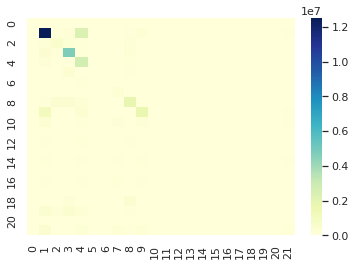

In [22]:
import seaborn as sns
sns.set_theme()

ax = sns.heatmap(df_cm, annot_kws={"size": 10}, fmt=".1f", cmap="YlGnBu")

## Displaying the Ground Truth against the Predicted Segmentation Results

The RGB ground truths and the predicted results are displayed side-by-side.

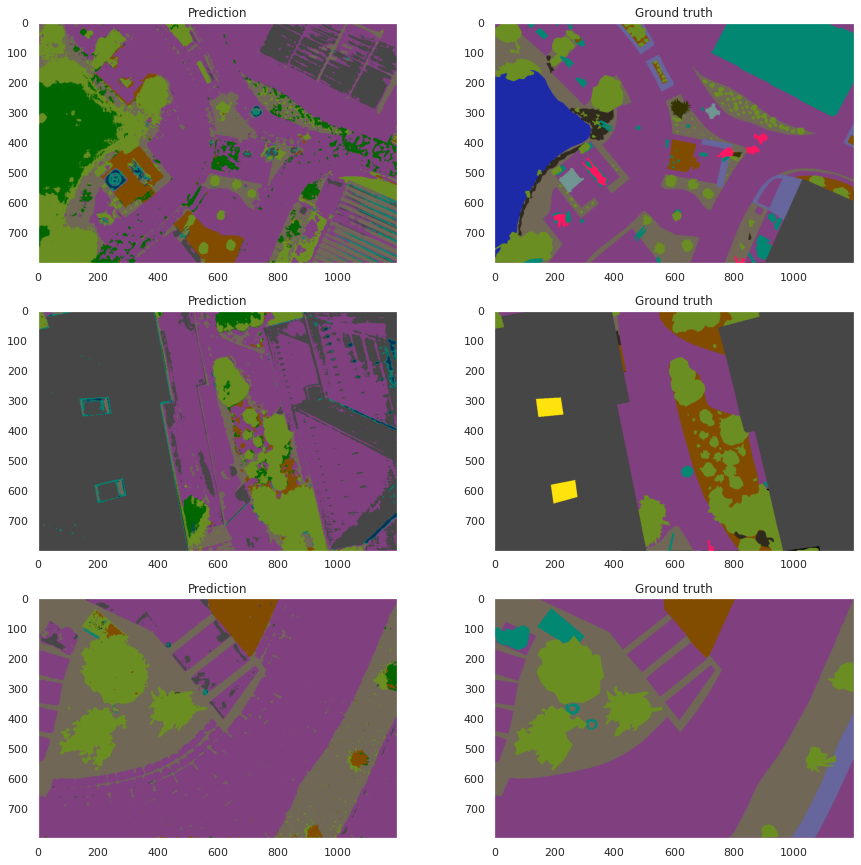

In [23]:
cmap = np.array(list(df[[' r', ' g', ' b']].transpose().to_dict('list').values()))
predictions = predictions.reshape(-1, 800, 1200)
label = label.reshape(-1, 800, 1200)

i = 18

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(cmap[predictions[i+j]])
    ax[j, 1].imshow(cmap[label[i+j]])
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
    ax[j, 0].grid(False)
    ax[j, 1].grid(False)
    
plt.show()

